# Explorando Cartpole con Reinforcement Learning usando Deep Q-learning

Este cuaderno es una modificación del tutorial de [Pytorch RL DQN](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
 
Sigue la línea de clase de Reinforcement Learning, Q-learning & OpenAI de la RIIA 2019

In [2]:
# Veamos de qué se trata el ambiente de Cartpole:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(30):
    env.render()
    env.step(env.action_space.sample()) # Toma acción aleatoria
env.close()

In [1]:
# Importamos las bibliotecas necesarias:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
plt.ion()
from collections import namedtuple
from itertools import count
from PIL import Image
# Las soluciones usan pytorch, pueden usar keras y/o tensorflow si prefieren
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# Ambiente de OpenAI "Cart pole"
enviroment = gym.make('CartPole-v0').unwrapped
enviroment.render()

# Revisa si hay GPU disponible y lo utiliza
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
print('Número de acciones: {}'.format(enviroment.action_space.n))
print('Dimensión de estado: {}'.format(enviroment.observation_space))

# Factor de descuento temporal
gamma = 0.8
# Número de muestras que extraer del repositorio de experiencia para entrenar la red
No_grupo = 64
# Parámetros para la tasa de epsilon-gredy, ésta va cayendo exponencialmente
eps_inicial = 0.9
eps_final = 0.05
eps_tasa = 200
# Parámetro para el descenso por gradiente estocástico
lr = 0.001
# Cada cuanto actualizar la red de etiqueta
actualizar_red_med = 10
# Número de episodios para entrenar
No_episodios = 200  
iters = 0
duracion_episodios = []


Número de acciones: 2
Dimensión de estado: Box(4,)


Define una función llamda `genera_accion` que reciba el vector del `estado` y tome la acción óptima o una acción aleatoria. La acción aleatoria la debe de tomar con una probabilidad que disminuya exponencialmente, de tal manera que en un principio se explore más.


Con probabilidad $$\epsilon_{final}+(\epsilon_{inicial}-\epsilon_{final})\times e^{-iters/tasa_{\epsilon}}$$ se escoge una acción aleatoria. En la siguiente gráfica se puede observar la tasa que cae exponencialmente.

<function matplotlib.pyplot.show(*args, **kw)>

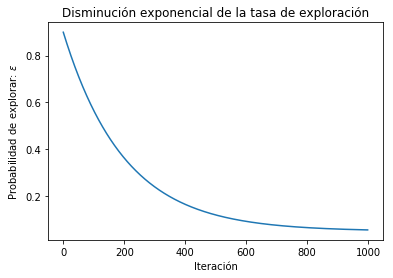

In [3]:
plt.plot([eps_final + (eps_inicial - eps_final) * math.exp(-1. * iters / eps_tasa) for iters in range(1000)])
plt.title('Disminución exponencial de la tasa de exploración')
plt.xlabel('Iteración')
plt.ylabel('Probabilidad de explorar: $\epsilon$')
plt.show

In [5]:
def genera_accion(estado):
    global iters
    decimal = random.uniform(0, 1) 
    limite_epsilon = eps_final + (eps_inicial - eps_final) * math.exp(-1. * iters / eps_tasa)
    iters += 1
    if decimal > limite_epsilon:
        with torch.no_grad():
            return red_estrategia(estado).max(0)[1].view(1)
    else:
        return torch.tensor([random.randrange(2)], device=device, dtype=torch.long)


Genera una red neuronal que reciba el vector de estado y regrese un vector de dimensión igual al número de acciones

In [6]:
class red_N(nn.Module):
    def __init__(self):
        super(red_N, self).__init__()
        # Capas densas
        self.capa_densa1 = nn.Linear(4, 256)  
        self.capa_densa2 = nn.Linear(256, 128)
        self.final = nn.Linear(128, 2)

    def forward(self, x):
        # Arquitectura de la red, con activación ReLU en las dos capas interiores
        x = F.relu(self.capa_densa1(x))
        x = F.relu(self.capa_densa2(x))
        return self.final(x)

En a siguiente celda generamos una clase de repositorio de experiencia con diferentes atributos:


`guarda`: guarda la observación $(s_i,a_i,s_i',r_i)$

`muestra`: genera una muestra de tamaño No_gupo

`len`: función que regresa la cantidad de muestras en el repositorio

In [7]:
Transicion = namedtuple('Transicion',
                        ('estado', 'accion', 'sig_estado', 'recompensa'))


class repositorioExperiencia(object):

    def __init__(self, capacidad):
        self.capacidad = capacidad
        self.memoria = []
        self.posicion = 0

    def guarda(self, *args):
        """Guarda una transición."""
        if len(self.memoria) < self.capacidad:
            self.memoria.append(None)
        self.memoria[self.posicion] = Transicion(*args)
        self.posicion = (self.posicion + 1) % self.capacidad

    def muestra(self, batch_size):
        return random.sample(self.memoria, batch_size)

    def __len__(self):
        return len(self.memoria)

En la siguiente celda definimos una función llamda `actualiza_q` que implemente DQL:
    
1. Saque una muestra de tamaño `No_grupo`, 
2. Usando la `red_estrategia`, calcule $Q_{\theta}(s_t,a_t)$ para la muestra
3. Calcula $V^*(s_{t+1})$ usando la `red_etiqueta`
4. Calcular la etiquetas $y_j=r_i+\max_aQ_{\theta'}(s_t,a)$
5. Calcula función de pérdida para $Q_{\theta}(s_t,a_t)-y_j$
6. Actualize $\theta$

In [8]:
def actualiza_q():
    if len(memoria) < No_grupo:
        return
    transiciones = memoria.muestra(No_grupo)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    grupo = Transicion(*zip(*transiciones))

    # Compute a mask of non-final states and concatenate the batch elements
    estados_intermedios = torch.tensor(tuple(map(lambda s: s is not None,
                                          grupo.sig_estado)), device=device, dtype=torch.uint8)
    sig_estados_intermedios = torch.cat([s for s in grupo.sig_estado
                                                if s is not None])
    grupo_estado = torch.cat(grupo.estado)
    accion_grupo = torch.cat(grupo.accion)
    recompensa_grupo = torch.cat(grupo.recompensa)

    # Calcula Q(s_t, a_t) - una manera es usar la red_estrategia para calcular Q(s_t), 
    # y seleccionar las columnas usando los índices de la acciones tomadas usando la función gather
    q_actual = red_estrategia(grupo_estado).gather(1, accion_grupo.unsqueeze(1))

    # Calcula V*(s_{t+1}) para todos los sig_estados en el grupo usando la red_etiqueta
    valores_sig_estado = torch.zeros(No_grupo, device=device)
    valores_sig_estado[estados_intermedios] = red_etiqueta(sig_estados_intermedios).max(1)[0].detach()
    # Calcular las etiquetas
    y_j = (valores_sig_estado * gamma) + recompensa_grupo

    # Calcula función de pérdida de Huber
    #perdida = F.smooth_l1_loss(q_actual, y_j.unsqueeze(1))
    perdida = F.mse_loss(q_actual, y_j.unsqueeze(1))

    # Optimizar el modelo
    optimizador.zero_grad()
    perdida.backward()
    for param in red_estrategia.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizador.step()

In [9]:
# Función para graficar la duración
def grafica_duracion(dur):
    plt.figure(2)
    plt.clf()
    duracion_t = torch.tensor(duracion_episodios, dtype=torch.float)
    plt.title('Entrenamiento...')
    plt.xlabel('Episodio')
    plt.ylabel('Duración')
    plt.plot(duracion_t.numpy())
    # Toma el promedio de duración d 100 episodios y los grafica
    if len(duracion_t) >= 15:
        media = duracion_t.unfold(0, 15, 1).mean(1).view(-1)
        media = torch.cat((torch.zeros(14), media))
        plt.plot(media.numpy())
        plt.plot([200]*len(duracion_t))
        

    plt.pause(dur)  # Pausa un poco para poder veer las gráficas
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [10]:
red_estrategia = red_N().to(device)
red_etiqueta = red_N().to(device)
red_etiqueta.load_state_dict(red_estrategia.state_dict())
red_etiqueta.eval()

#optimizador = optim.RMSprop(red_estrategia.parameters())
optimizador = optim.Adam(red_estrategia.parameters(),lr=lr)
memoria = repositorioExperiencia(10000)


In [11]:
# Entrenamiento
for episodio in range(0, No_episodios):
    # Reset the enviroment
    estado = enviroment.reset()
    estado = torch.tensor(estado, dtype = torch.float)

    # Initialize variables
    recompensa = 0
    termina = False
    
    for t in count():
        # Decide acción a tomar
        accion = genera_accion(estado)
        # Implementa la acción y recibe reacción del ambiente
        sig_estado, recompensa, termina, _ = enviroment.step(accion.item())
        # Convierte a observaciones a tensores
        estado = torch.tensor(estado, dtype = torch.float)
        sig_estado = torch.tensor(sig_estado, dtype = torch.float)
        # Si acabó (Termina = True) el episodio la recompensa es negativa
        if termina:
            recompensa = -recompensa

        recompensa = torch.tensor([recompensa], device=device)
        

        # Guarda la transición en la memoria
        memoria.guarda(estado.unsqueeze(0), accion, sig_estado.unsqueeze(0), recompensa)

        # Actualiza valor q en la red de medida
        actualiza_q()
        ## Moverse al siguiente estado
        estado = sig_estado
        # Grafica la duración de los episodios
        if termina:
            duracion_episodios.append(t + 1)
            break
    # Actualizar la red_etiqueta
    if episodio % actualizar_red_med == 0:
        red_etiqueta.load_state_dict(red_estrategia.state_dict())
        grafica_duracion(0.3)
print("**********************************")
print("Entrenamiento finalizado!\n")
print("**********************************")
grafica_duracion(15)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [23]:
grafica_duracion(15)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>